# EA x DKSG
**classification: web scrape**

classify organizations into cause areas based on descriptions
- basically, descriptions -> cause areas

## methodology
- clean up organization descriptions
    - drop stopwords
    - drop punctuations
    - lemmatize words
- create count vectors for each description
- use count vectors as feature for classification with
    - decision trees
    - random forest regressor
    
## hypothesis
an organization with certain keywords in its description should be involved in a cause area if the keywords match up with the keywords defined in the cause area

## clean up organization descriptions

In [2]:
## setup
import pandas as pd
%run env_setup.py
%run filepaths.py
%run helpers.py
None

In [3]:
web_df = read_from_csv(WEB_SCRAPE_CSV)
web_df.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,Charity.Status,Date.of.Charity.Registration,IPC.Status,IPC.Period,Details.URL,fax,revenue,employees,lat,lon
0,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.673612,115.203737
1,2,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.675090,115.189919
2,3,NGO 4 Ger,Only for specials,http://www.fiedbeck.de,Balinese People,NaN,Strasse 1 Bali,indonesia,Amed,+49 7531 123456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.409518,115.188916
3,4,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.653567,115.172545
4,5,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.683880,115.518827


In [4]:
## fill up empty descriptions
web_df['description'] = web_df['description'].fillna('')

## add cleaned description
web_df['desc_clean_words'] = get_cleaned_descriptions(list(web_df['description']), True, True, True)
web_df['desc_clean'] = get_sentence_from_list(list(web_df['desc_clean_words']))

Q: number/proportion of organizations with descriptions

In [5]:
orgs_with_description_index = web_df['description'].apply(lambda d: None if d == '' else d).dropna().index

number_of_orgs_with_description = len(orgs_with_description_index)
number_of_orgs_with_description

print("Number of organizations with descriptions: %d" % number_of_orgs_with_description)
print("% of organizations with descriptions: "+ str(number_of_orgs_with_description/len(web_df)))

Number of organizations with descriptions: 10364
% of organizations with descriptions: 0.6980534788172695


## clean up cause areas

In [6]:
import re

## add cleaned cause areas
def clean_cause_area(cause_area_raw):
    sentence = cause_area_raw
    sentence = re.sub(r'(&)|(and)',',',sentence)
    sentence = re.sub(r'[()1-9]+',' ',sentence)
    sentence = sentence.replace("."," ").replace("-"," ")
    sentence = sentence.replace("\\",",").replace("/",",")
    sentence = re.sub(r'[^a-zA-Z0-9,]',' ', sentence)
    
    def remove_single_char_word_in_cause_area(cause_area):
        w = cause_area.split(" ")
        w = [w for w in w if len(w) > 1]
        return " ".join(w)
    
    words = sentence.lower().split(",")
    words = [w.strip() for w in words]
    words = [re.sub(r'[ ]{2,}',' ', w) for w in words]
    words = [remove_single_char_word_in_cause_area(w) for w in words]
    words = [w for w in words if len(w) > 0]
    return set(words)

web_df['cause_area'] = web_df['cause_area'].fillna('')
web_df['cause_area_clean'] = web_df['cause_area'].apply(clean_cause_area)
web_df['cause_area_count'] = web_df['cause_area_clean'].apply(lambda l: len(l))

view existing cause areas

In [7]:
web_df[['desc_clean_words', 'desc_clean', 'cause_area_clean', 'cause_area_count']].head()

,desc_clean_words,desc_clean,cause_area_clean,cause_area_count
0,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{health, balinese people}",2
1,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{children, balinese people, culture, balinese ...",4
2,"[only, special]",only special,{balinese people},1
3,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education, children, schools}",3
4,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,"{nature conservation, environment}",2


## basic viz

In [8]:
%matplotlib inline
%run viz_setup.py

#### cause areas (web scraped)

In [9]:
from itertools import chain
def get_web_cause_area_summary(web_df):
    df = list(chain.from_iterable(list(web_df['cause_area_clean'].apply(lambda s: list(s)))))
    df = pd.Series(df) 
    df = pd.DataFrame(df.value_counts().reset_index())
    df.columns = ['cause area', 'count']
    
    total_cause_area_count = sum(df['count'])
    df['%'] = df['count'].apply(lambda count: count/total_cause_area_count)
    
    return df

web_cause_area_df = get_web_cause_area_summary(web_df)

In [10]:
print("Number of unique cause areas: %d" % len(web_cause_area_df))

Number of unique cause areas: 392


Q: top 20 cause areas with highest counts

In [11]:
web_cause_area_df[:20]

,cause area,count,%
0,religious,1085,0.107543
1,education,720,0.071365
2,children,670,0.066409
3,health,488,0.048370
4,social,461,0.045693
5,support groups,448,0.044405
6,welfare,392,0.038854
7,environment,314,0.031123
8,youth,281,0.027852
9,charitable,242,0.023987


Q: cause area by counts bar chart (all)

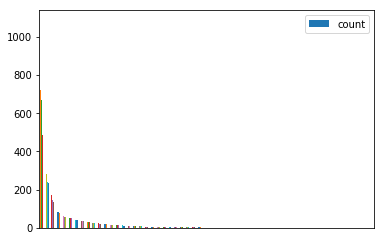

In [12]:
plt = web_cause_area_df.plot.bar(x='cause area', y='count')
plt.xaxis.set_visible(False)

Q: cause area by counts bar chart (top 20)

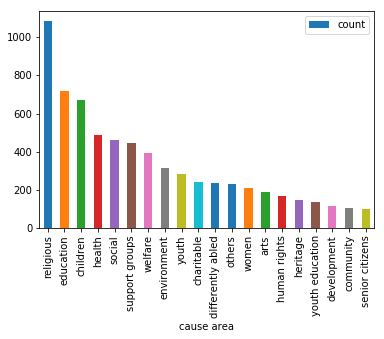

In [13]:
plt = web_cause_area_df[:20].plot.bar(x='cause area', y='count')
plt

#### distribution of number of organizations to cause area counts

    number of cause areas  number of organizations
0                       0                     8429
1                       1                     4065
2                       2                     1703
3                       3                      378
4                       4                      129
5                       5                       61
6                       6                       30
7                       7                       26
8                       8                        6
9                      10                        4
10                     12                        3
11                     11                        3
12                      9                        3
13                     13                        2
14                     14                        1
15                     20                        1
16                     17                        1
17                     21                        1
18                     19      

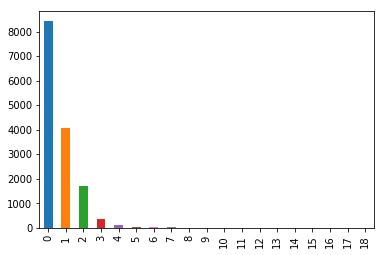

In [14]:
cause_area_count_distribution = pd.DataFrame(web_df['cause_area_count'].value_counts().reset_index())
cause_area_count_distribution.columns = ['number of cause areas','number of organizations']

print(cause_area_count_distribution)
cause_area_count_distribution['number of organizations'].plot.bar()

#### cause areas (web scraped) for organizations with non-empty descriptions
- it is meaningless to train a classifier with observations with empty descriptions

In [15]:
web_cause_area_nonempty_df = get_web_cause_area_summary(web_df[web_df['desc_clean'] != ''])

print("- After Filtering out organizations with empty descriptions -")
print("number of unique cause areas: %d" % len(web_cause_area_nonempty_df))
web_cause_area_nonempty_df[:20]

- After Filtering out organizations with empty descriptions -
number of unique cause areas: 353


,cause area,count,%
0,children,532,0.104049
1,education,411,0.080383
2,support groups,358,0.070018
3,health,253,0.049482
4,charitable,242,0.047330
5,environment,225,0.044005
6,youth,194,0.037942
7,women,178,0.034813
8,differently abled,176,0.034422
9,youth education,134,0.026208


## create features: count vectors for each description
- take top web_cause_areas by count

In [16]:
## ml setup
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score

#### select top cause areas (web scrape)
n = 50

In [17]:
web_cause_area_select = web_cause_area_nonempty_df[:50]

Q: proportion of top web cause areas (against all counts)

In [18]:
sum(web_cause_area_select['%'])

0.8488167416389595

create cause_area_clean_filter (ie. a copy of cause_area_clean with only filtered matches)

In [19]:
web_df['cause_area_clean_filter'] = \
    web_df['cause_area_clean'].apply(lambda c: c.intersection(set(web_cause_area_select['cause area'])))

#### select orgs in selected cause areas
select orgs that are within selected cause areas, and do not have empty descriptions

In [20]:
def select_orgs_in_cause_area(df):
    orgs_with_non_empty_descriptions = df['desc_clean'] \
        .apply(lambda desc: None if desc == '' else desc) \
        .dropna() \
        .index
    
    orgs_with_at_least_one_cause_area = df.iloc[orgs_with_non_empty_descriptions] \
        ['cause_area_clean_filter'] \
        .apply(lambda c: len(c) if len(c) > 0 else None) \
        .dropna() \
        .index
    
    return df.iloc[orgs_with_at_least_one_cause_area]

web_df_select = select_orgs_in_cause_area(web_df)
web_df_select.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_count,cause_area_clean_filter
0,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,...,NaN,NaN,NaN,-8.673612,115.203737,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{health, balinese people}",2,{health}
1,2,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,...,NaN,NaN,NaN,-8.675090,115.189919,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{children, balinese people, culture, balinese ...",4,"{children, culture}"
3,4,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,...,NaN,NaN,NaN,-8.653567,115.172545,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education, children, schools}",3,"{education, children}"
4,5,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,...,NaN,NaN,NaN,-8.683880,115.518827,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,"{nature conservation, environment}",2,{environment}
5,6,Bali Street Kids Project (YKPA),Helping children in the streets for 13 yrs bec...,http://www.ykpa.org,"Balinese People, Children, Women & Women's Rig...","To give loving support, education, care, and s...","Jl. Gn. Payung No.23, Padangsambian Klod, Denp...",indonesia,Denpasar,+62 361 8037322,...,NaN,NaN,NaN,-8.684866,115.180191,"[helping, child, street, 13, yr, school, class...",helping child street 13 yr school class beach ...,"{balinese people, schools, children, women, ed...",6,"{education, children, women}"


Q: total number of organizations after filtering

In [21]:
len(web_df_select)

2431

#### split train/test/validation

In [22]:
train_ratio, test_ratio, validation_ratio_from_test = (0.7,0.3,0.5)

In [23]:
def do_train_test_validation_split(df, train_ratio, test_ratio, validation_ratio_from_test, random_state=None):
    train_data, test_data = \
        train_test_split(df, train_size=train_ratio, test_size=test_ratio, random_state=random_state)
    validation_data, test_data = \
        train_test_split(test_data, train_size=validation_ratio_from_test, 
                          test_size=1-validation_ratio_from_test, random_state=random_state)
            
    return train_data, test_data, validation_data
    
train_data, test_data, validation_data = \
    do_train_test_validation_split(web_df_select, train_ratio, test_ratio, validation_ratio_from_test, 1)

train/test/validation counts

In [24]:
print("train count: %d" % len(train_data))
print("test count: %d" % len(test_data))
print("validation count: %d" % len(validation_data))

train count: 1701
test count: 365
validation count: 365


train/test/validation counts by cause area

- to check that each cause area is represented in test/train/validation

In [25]:
def generate_data_split_cause_area_counts(train_data, test_data, validation_data, cause_areas):
    def get_number_of_orgs_that_match_cause_area(df, cause_area):
        return df['cause_area_clean_filter'] \
            .apply(lambda causes: causes if cause_area in causes else None) \
            .dropna() \
            .count()
    
    split_counts = []
    for cause_area in cause_areas:
        split_counts.append({
            'cause area': cause_area,
            'train': get_number_of_orgs_that_match_cause_area(train_data, cause_area),
            'test': get_number_of_orgs_that_match_cause_area(test_data, cause_area),
            'validation': get_number_of_orgs_that_match_cause_area(validation_data, cause_area),
        })
    
    return split_counts

split_data_cause_area_counts = pd.DataFrame(
    generate_data_split_cause_area_counts(train_data, test_data, validation_data, set(web_cause_area_select['cause area']))
)
split_data_cause_area_counts

,cause area,test,train,validation
0,community improvement,3,12,2
1,other communities,7,36,14
2,nan,1,10,3
3,arts,1,17,6
4,culture,5,22,9
5,refugees,3,11,3
6,children,79,372,81
7,livelihood,4,13,2
8,girls,7,36,6
9,orang asli,5,11,2


Q: are all cause areas represented in all of the data sets? (ie. no 0 counts in any of the cause areas)

In [26]:
def get_zero_counts_cause_areas_from_datasets(df):
    return df.query('test == 0 | train == 0 | validation == 0')
    
zero_counts_cause_areas = get_zero_counts_cause_areas_from_datasets(split_data_cause_area_counts)
len(zero_counts_cause_areas) > 0

True

#### encode org descriptions using CountVectorizer

In [27]:
count_vectorizer = CountVectorizer(max_features=100, decode_error='ignore')

train_data_feat = count_vectorizer.fit_transform(train_data['desc_clean'])
test_data_feat = count_vectorizer.transform(test_data['desc_clean'])
validation_data_feat = count_vectorizer.transform(validation_data['desc_clean'])

## create labels: cause area categories
#### encode cause area categories to multi-label

In [28]:
mlb = MultiLabelBinarizer()
mlb.fit([web_cause_area_select['cause area']])
mlb.classes_

array(['advocacy', 'animal welfare', 'animals', 'arts', 'cambodia',
       'capacity building', 'charitable', 'child', 'children',
       'civic empowerment', 'community improvement', 'community service',
       'cultural', 'culture', 'development', 'differently abled',
       'disabilities', 'economic development', 'education', 'educational',
       'environment', 'families', 'girls', 'health',
       'health disaster relief', 'human rights', 'hunger', 'livelihood',
       'medical', 'nan', 'orang asli', 'other communities',
       'overseas aid', 'poverty', 'recommended', 'refugees', 'religious',
       'research', 'senior citizens', 'single parents',
       'social development', 'social enterprise', 'social welfare',
       'support groups', 'welfare community development', 'women',
       'women other', 'youth', 'youth development', 'youth education'],
      dtype=object)

In [29]:
validation_data.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_count,cause_area_clean_filter
10632,10633,National Council On Social Welfare Of Thailand...,National Council on Social Welfare of Thailand...,http://www.ncswt.or.th,"Disabilities,",NaN,NaN,thailand,Bangkok,NaN,...,NaN,NaN,NaN,NaN,NaN,"[national, council, social, welfare, thailand,...",national council social welfare thailand ncswt...,{disabilities},1,{disabilities}
4129,4130,Sri Murugan Center,The Sri Murugan Centre (SMC) was founded in Se...,http://www.smc.com.my/,Education/Youth,NaN,"No.40, Jalan Bukit 11/2, 46200 Petaling Jaya, ...",malaysia,NaN,+603 7957 0112,...,NaN,NaN,NaN,3.113834,101.649895,"[the, sri, murugan, centre, smc, found, septem...",the sri murugan centre smc found september 24 ...,"{education, youth}",2,"{education, youth}"
3569,3570,"Malaysian Red Crescent Society, Tuaran Chapter",BACKGROUND/HISTORY\nThe Malaysian Red Crescent...,http://www.facebook.com/Malaysian-Red-Crescent...,Children/Health/Orang Asli/Senior Citizens/Wom...,NaN,"PBSMM Chapter Tuaran, P.O. Box 161, Jalan Seka...",NaN,NaN,088-24 2648,...,NaN,NaN,NaN,7.973377,98.343880,"[background, history, \n, the, malaysian, red,...",background history \n the malaysian red cresce...,"{senior citizens, children, health, orang asli...",6,"{senior citizens, children, health, orang asli..."
4248,4249,Do Something Good,"\nIf you donÃ¢ÂÂt already know an NGO, chanc...",http://www.dosomething.gd,Support Groups/Talent/Youth,NaN,"2, Jalan 14/22 Seksyen 14 46100 Petaling Jaya ...",malaysia,NaN,+603-7957 1707,...,NaN,NaN,NaN,39.911970,-91.381930,"[\n, if, donã¢âât, know, ngo, chance, donã¢â...",\n if donã¢âât know ngo chance donã¢âât ne...,"{support groups, youth, talent}",3,"{support groups, youth}"
10126,10127,"Bato-Balani Foundation, Inc.",Company Description:\nBato-Balani Foundation I...,www.batobalanifoundation.org.ph,"Charitable,Educational",NaN,"6/F PDCP Bank Centre, Rufino corner Leviste St...",NaN,NaN,NaN,...,NaN,NaN,NaN,14.560048,121.019489,"[company, description, \n, bato, balani, found...",company description \n bato balani foundation ...,"{educational, charitable}",2,"{educational, charitable}"


In [30]:
train_data_label = mlb.transform(train_data['cause_area_clean_filter'])
test_data_label = mlb.transform(test_data['cause_area_clean_filter'])
validation_data_label = mlb.transform(validation_data['cause_area_clean_filter'])

## classify orgs

In [31]:
base_clf = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1)
base_clf = base_clf.fit(train_data_feat, train_data_label)

test_predict = base_clf.predict(test_data_feat)
train_predict = base_clf.predict(train_data_feat)
validation_predict = base_clf.predict(validation_data_feat)

## classifier performance

In [32]:
## accuracy helper
def get_accuracy(true_labels, predicted_labels):
    accuracies = {}
    
    predicted_classes = list(mlb.classes_)
    for cause_area in web_cause_area_select['cause area']:
        index = predicted_classes.index(cause_area)
        accuracy = accuracy_score(
            [a[index] for a in true_labels],
            [a[index] for a in predicted_labels]
        )
        accuracies[cause_area] = accuracy
        
    return accuracies

on train data

In [33]:
pre_optimization_train_acc = get_accuracy(train_data_label, train_predict)
pre_optimization_train_acc

{'children': 0.9882422104644327,
 'education': 0.9676660787771899,
 'support groups': 0.993533215755438,
 'health': 0.9876543209876543,
 'charitable': 1.0,
 'environment': 0.9835390946502057,
 'youth': 0.9958847736625515,
 'women': 0.9970605526161082,
 'differently abled': 0.9952968841857731,
 'youth education': 0.9994121105232217,
 'human rights': 0.9853027630805409,
 'educational': 0.9964726631393298,
 'social development': 0.9994121105232217,
 'senior citizens': 0.9976484420928865,
 'advocacy': 0.9929453262786596,
 'social enterprise': 0.9988242210464433,
 'overseas aid': 0.9970605526161082,
 'other communities': 0.9982363315696648,
 'hunger': 0.9982363315696648,
 'welfare community development': 0.9994121105232217,
 'poverty': 0.9970605526161082,
 'recommended': 0.9976484420928865,
 'girls': 0.9994121105232217,
 'families': 0.9988242210464433,
 'medical': 0.9976484420928865,
 'disabilities': 0.9982363315696648,
 'research': 0.9952968841857731,
 'health disaster relief': 0.999412110

on test data

In [34]:
get_accuracy(test_data_label, test_predict)

{'children': 0.863013698630137,
 'education': 0.8547945205479452,
 'support groups': 0.8712328767123287,
 'health': 0.9013698630136986,
 'charitable': 0.9972602739726028,
 'environment': 0.8821917808219178,
 'youth': 0.936986301369863,
 'women': 0.9506849315068493,
 'differently abled': 0.9424657534246575,
 'youth education': 0.9698630136986301,
 'human rights': 0.9452054794520548,
 'educational': 0.9534246575342465,
 'social development': 0.9671232876712329,
 'senior citizens': 0.9671232876712329,
 'advocacy': 0.9808219178082191,
 'social enterprise': 0.9698630136986301,
 'overseas aid': 0.9808219178082191,
 'other communities': 0.9808219178082191,
 'hunger': 0.9698630136986301,
 'welfare community development': 0.9726027397260274,
 'poverty': 0.9698630136986301,
 'recommended': 0.9726027397260274,
 'girls': 0.9808219178082191,
 'families': 0.9780821917808219,
 'medical': 0.9780821917808219,
 'disabilities': 0.9835616438356164,
 'research': 0.989041095890411,
 'health disaster relief'

on validation data (but **not** used as metric, since it will be used for next section)

In [35]:
pre_optimization_validation_acc = get_accuracy(validation_data_label, validation_predict)
pre_optimization_validation_acc

{'children': 0.8082191780821918,
 'education': 0.8356164383561644,
 'support groups': 0.8328767123287671,
 'health': 0.8958904109589041,
 'charitable': 1.0,
 'environment': 0.915068493150685,
 'youth': 0.9232876712328767,
 'women': 0.9452054794520548,
 'differently abled': 0.915068493150685,
 'youth education': 0.9780821917808219,
 'human rights': 0.9643835616438357,
 'educational': 0.9726027397260274,
 'social development': 0.9643835616438357,
 'senior citizens': 0.9753424657534246,
 'advocacy': 0.9616438356164384,
 'social enterprise': 0.9780821917808219,
 'overseas aid': 0.9726027397260274,
 'other communities': 0.9616438356164384,
 'hunger': 0.9753424657534246,
 'welfare community development': 0.989041095890411,
 'poverty': 0.9753424657534246,
 'recommended': 0.9835616438356164,
 'girls': 0.9835616438356164,
 'families': 0.9863013698630136,
 'medical': 0.9698630136986301,
 'disabilities': 0.9753424657534246,
 'research': 0.989041095890411,
 'health disaster relief': 0.991780821917

Q: mean train/test/validation accuracies

In [36]:
print('mean train acc: %f' % np.average(list(pre_optimization_train_acc.values())))
print('mean test acc: %f' % np.average(list(get_accuracy(test_data_label, test_predict).values())))
print('mean validation acc: %f' % np.average(list(pre_optimization_validation_acc.values())))

mean train acc: 0.996167
mean test acc: 0.969370
mean validation acc: 0.967726


## classification (optimization)
improve model performance on test/validation data
- since model does very well on train data, we don't need a more complex model
- however, since test accuracy is far lower than train accuracy, model is overfitting
- thus, reduce overfitting by optimizing model hyperparameters
- use grid search to find best model hyperparameters

#### complexity of current model
random forest classifier parameters

In [37]:
base_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

1st decision tree's parameters

In [38]:
base_clf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1415006252, splitter='best')

max_depth and node_count of all decision trees

In [39]:
def get_random_tree_statistics(random_tree):
    def get_attributes(tree):
        return {
            'max_depth': tree.max_depth,
            'node_count': tree.node_count,
        }
    
    return [get_attributes(t.tree_) for t in random_tree.estimators_]

base_clf_statistics = get_random_tree_statistics(base_clf)
base_clf_statistics

[{'max_depth': 48, 'node_count': 1707},
 {'max_depth': 59, 'node_count': 1661},
 {'max_depth': 56, 'node_count': 1719},
 {'max_depth': 48, 'node_count': 1645},
 {'max_depth': 50, 'node_count': 1765},
 {'max_depth': 53, 'node_count': 1699},
 {'max_depth': 52, 'node_count': 1751},
 {'max_depth': 51, 'node_count': 1679},
 {'max_depth': 59, 'node_count': 1685},
 {'max_depth': 49, 'node_count': 1747},
 {'max_depth': 48, 'node_count': 1707},
 {'max_depth': 56, 'node_count': 1719},
 {'max_depth': 57, 'node_count': 1723},
 {'max_depth': 52, 'node_count': 1671},
 {'max_depth': 56, 'node_count': 1713},
 {'max_depth': 49, 'node_count': 1685},
 {'max_depth': 48, 'node_count': 1729},
 {'max_depth': 57, 'node_count': 1657},
 {'max_depth': 56, 'node_count': 1661},
 {'max_depth': 49, 'node_count': 1689},
 {'max_depth': 51, 'node_count': 1681},
 {'max_depth': 44, 'node_count': 1723},
 {'max_depth': 56, 'node_count': 1739},
 {'max_depth': 53, 'node_count': 1763},
 {'max_depth': 55, 'node_count': 1687}]

Q: median tree max depth

In [40]:
np.median([x['max_depth'] for x in base_clf_statistics])

52.0

Q: median tree node count

In [41]:
np.median([x['node_count'] for x in base_clf_statistics])

1707.0

#### bounds and parameters for grid search
since the objective is to reduce model complexity, the following parameters can be explored to find the best hyperparameters for the model
- n_estimators (5-50, increments of 5): lower = less overfitting
- max_depth (5-20): lower = less overfitting
- min_samples_leaf (1-10): higher = less overfitting
- min_samples_split (2-10): higher = less overfitting

In [42]:
n_estimators_range = range(5,50+1,10)
max_depth_range = range(5,20+1)
min_samples_leaf_range = range(1,10+1)
min_samples_split_range = range(2,10+1)

generate hyperparameters

In [43]:
from collections import namedtuple
import random

dt_hyperparameters = namedtuple('hyperparameters','n_estimators max_depth min_samples_leaf min_samples_split')
def create_dt_hyperparameters():
    return dt_hyperparameters(
        random.choice(n_estimators_range),
        random.choice(max_depth_range),
        random.choice(min_samples_leaf_range),
        random.choice(min_samples_split_range),
    )

dt_hyperparameters_list = [create_dt_hyperparameters() for x in range(1,100)]
dt_hyperparameters_list[:5]

[hyperparameters(n_estimators=25, max_depth=18, min_samples_leaf=1, min_samples_split=10),
 hyperparameters(n_estimators=35, max_depth=11, min_samples_leaf=6, min_samples_split=2),
 hyperparameters(n_estimators=25, max_depth=17, min_samples_leaf=6, min_samples_split=7),
 hyperparameters(n_estimators=5, max_depth=15, min_samples_leaf=2, min_samples_split=10),
 hyperparameters(n_estimators=15, max_depth=9, min_samples_leaf=9, min_samples_split=10)]

define classify function for hyperameter search

In [44]:
def do_classify(model_params):
    clf = ensemble.RandomForestClassifier(
        n_estimators = model_params.n_estimators,
        max_depth = model_params.max_depth,
        min_samples_leaf = model_params.min_samples_leaf,
        min_samples_split = model_params.min_samples_split,
        n_jobs = -1)
    clf = clf.fit(train_data_feat, train_data_label)
    
    test_predict = clf.predict(test_data_feat)
    train_predict = clf.predict(train_data_feat)
    validation_predict = clf.predict(validation_data_feat)
    
    train_acc = get_accuracy(train_data_label, train_predict)
    test_acc = get_accuracy(test_data_label, test_predict)
    validation_acc = get_accuracy(validation_data_label, validation_predict)
    
    return {
        'model_params': model_params,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'validation_acc': validation_acc,
        'mean_train_acc': np.average(list(train_acc.values())),
        'mean_test_acc': np.average(list(test_acc.values())),
        'mean_validation_acc': np.average(list(validation_acc.values())),
        'clf': clf,
    }

do hyperparameter search

In [45]:
experiment_results = [do_classify(params) for params in dt_hyperparameters_list]

get hyperparameters with best mean test performance
- ie. using test set to optimize hyperparameters

In [46]:
top_hyperparameter = sorted(experiment_results, reverse=False, key=lambda e: e['mean_test_acc'])[0]
print("top hyperparameters: ", top_hyperparameter['model_params'])
print("mean train accuracy: %f" % top_hyperparameter['mean_train_acc'])
print("mean test accuracy: %f" % top_hyperparameter['mean_test_acc'])

top hyperparameters:  hyperparameters(n_estimators=25, max_depth=5, min_samples_leaf=3, min_samples_split=3)
mean train accuracy: 0.966631
mean test accuracy: 0.967123


mean validation accuracy of model (ie. actual performance of model on unseen data)

In [47]:
print("mean validation accuracy: %f" % top_hyperparameter['mean_validation_acc'])

mean validation accuracy: 0.966411


## predict descriptions with fully trained model

train random forest classifier with top hyperparameters and with all data

In [48]:
def train_best_clf(model_params):
    best_clf = ensemble.RandomForestClassifier(
        n_estimators = model_params.n_estimators,
        max_depth = model_params.max_depth,
        min_samples_leaf = model_params.min_samples_leaf,
        min_samples_split = model_params.min_samples_split,
        n_jobs = -1)

    best_clf.fit(train_data_feat, train_data_label)
    best_clf.fit(test_data_feat, test_data_label)
    best_clf.fit(validation_data_feat, validation_data_label)
    
    return best_clf

best_clf = train_best_clf(top_hyperparameter['model_params'])

predict descriptions of all entries (including organizations used for train/test/validation)

In [49]:
def do_predict_cause_area_on_descriptions(df):
    descriptions = count_vectorizer.transform(df['desc_clean'])
    predictions_raw = best_clf.predict(descriptions)
    predictions = mlb.inverse_transform(predictions_raw)
    return [set(s) for s in predictions]

web_df['cause_area_predict'] = do_predict_cause_area_on_descriptions(web_df)
web_df['cause_area_predict_count'] = web_df['cause_area_predict'].apply(lambda c: len(c))

Q: distribution of predicted cause areas for all organizations (nonempty descriptions)

In [56]:
web_df.iloc[orgs_with_description_index] \
        ['cause_area_predict_count'].value_counts()

0    10104
1      255
2        5
Name: cause_area_predict_count, dtype: int64

Q: distribution of predicted cause areas for all unobserved organizations (nonempty descriptions)

In [63]:
unobserved_observations_indexes = [n for n in orgs_with_description_index if n not in web_df_select.index]
web_df.iloc[unobserved_observations_indexes] \
    ['cause_area_predict_count'].value_counts()

0    7928
1       5
Name: cause_area_predict_count, dtype: int64

Note: **from these count distributions, we can see that the classifier isn't very good at imputing cause areas for new observations**

define new row that uses predicted cause areas, and overwrites predicted cause areas if the 'ground truth' cause area is present

In [52]:
web_df['cause_area_predict_final'] = web_df['cause_area_predict']

orgs_with_filtered_cause_areas = \
    web_df['cause_area_clean_filter'].apply(lambda s: s if len(s) > 0 else None).dropna().index
web_df['cause_area_predict_final'].loc[orgs_with_filtered_cause_areas] = \
    web_df['cause_area_clean_filter'].loc[orgs_with_filtered_cause_areas]
    
web_df.head()

/Users/gibson/.local/share/virtualenvs/effective_altruism-5IwjV9t-/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_count,cause_area_clean_filter,cause_area_predict,cause_area_predict_count,cause_area_predict_final
0,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,...,-8.673612,115.203737,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{health, balinese people}",2,{health},{},0,{health}
1,2,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,...,-8.675090,115.189919,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{children, balinese people, culture, balinese ...",4,"{children, culture}",{},0,"{children, culture}"
2,3,NGO 4 Ger,Only for specials,http://www.fiedbeck.de,Balinese People,NaN,Strasse 1 Bali,indonesia,Amed,+49 7531 123456,...,-8.409518,115.188916,"[only, special]",only special,{balinese people},1,{},{},0,{}
3,4,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,...,-8.653567,115.172545,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education, children, schools}",3,"{education, children}",{},0,"{education, children}"
4,5,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,...,-8.683880,115.518827,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,"{nature conservation, environment}",2,{environment},{},0,{environment}


## exporting results

create new dataframe in kelvin's format (for use with tableau map viz)

In [53]:
def to_kelvin_export_format(r):
    causes = list(r['cause_area_predict_final'])
    to_export = []
    
    for cause in causes:
        to_export.append(
            {
                'key': r['key'],
                'name': r['name'],
                'cause': cause,
            }
        )
        
    return to_export

to_export = list(chain.from_iterable([to_kelvin_export_format(row) for index, row in web_df.iterrows()]))

In [54]:
to_export_df = pd.DataFrame(to_export)
to_export_df[:20]

,cause,key,name
0,health,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...
1,children,2,Volunteer Programs Bali
2,culture,2,Volunteer Programs Bali
3,education,4,Bali Children Foundation
4,children,4,Bali Children Foundation
5,environment,5,Friends of the National Parks Foundation
6,education,6,Bali Street Kids Project (YKPA)
7,children,6,Bali Street Kids Project (YKPA)
8,women,6,Bali Street Kids Project (YKPA)
9,education,7,Bali Life Foundation


export dataframe to file

In [55]:
to_export_df.to_csv(OUTPUT_PATH+'/classify_cause_area/kelvin_tableau_export.csv')